In [1246]:
import cv2
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

# PnP to get Camera Estimation between 2 frames

## Setup Camera Params

In [1247]:
stereo_data = cv2.FileStorage('stereo_cameras.xaml', cv2.FileStorage_READ)
K1 = stereo_data.getNode('K1').mat()
K2 = stereo_data.getNode('K2').mat()

D1 = stereo_data.getNode('D1').mat()
D2 = stereo_data.getNode('D2').mat()


R1 = stereo_data.getNode('R1').mat()
R2 = stereo_data.getNode('R2').mat()

P1 = stereo_data.getNode('P1').mat()
P2 = stereo_data.getNode('P2').mat()

cam = cv2.VideoCapture('video.avi')

In [1248]:
for i in range(30):
    _,_ = cam.read()

_,im1 = cam.read()
_,im2 = cam.read()

In [1249]:
h,w,_ = im1.shape

im1L = im1[:,:w//2]
im1R = im1[:,w//2:]

im2L = im2[:,:w//2]
im2R = im2[:,w//2:]

In [1250]:
lmapx, lmapy = cv2.initUndistortRectifyMap(K1,D1,R1,P1, (w//2,int(h)), cv2.CV_32FC1)
rmapx, rmapy = cv2.initUndistortRectifyMap(K2,D2,R2,P2, (w//2,int(h)), cv2.CV_32FC1)

In [1251]:
im1L = cv2.remap(im1L, lmapx, lmapy, cv2.INTER_LINEAR)
im1R = cv2.remap(im1R, rmapx, rmapy, cv2.INTER_LINEAR)

im2L = cv2.remap(im2L, lmapx, lmapy, cv2.INTER_LINEAR)
im2R = cv2.remap(im2R, rmapx, rmapy, cv2.INTER_LINEAR)

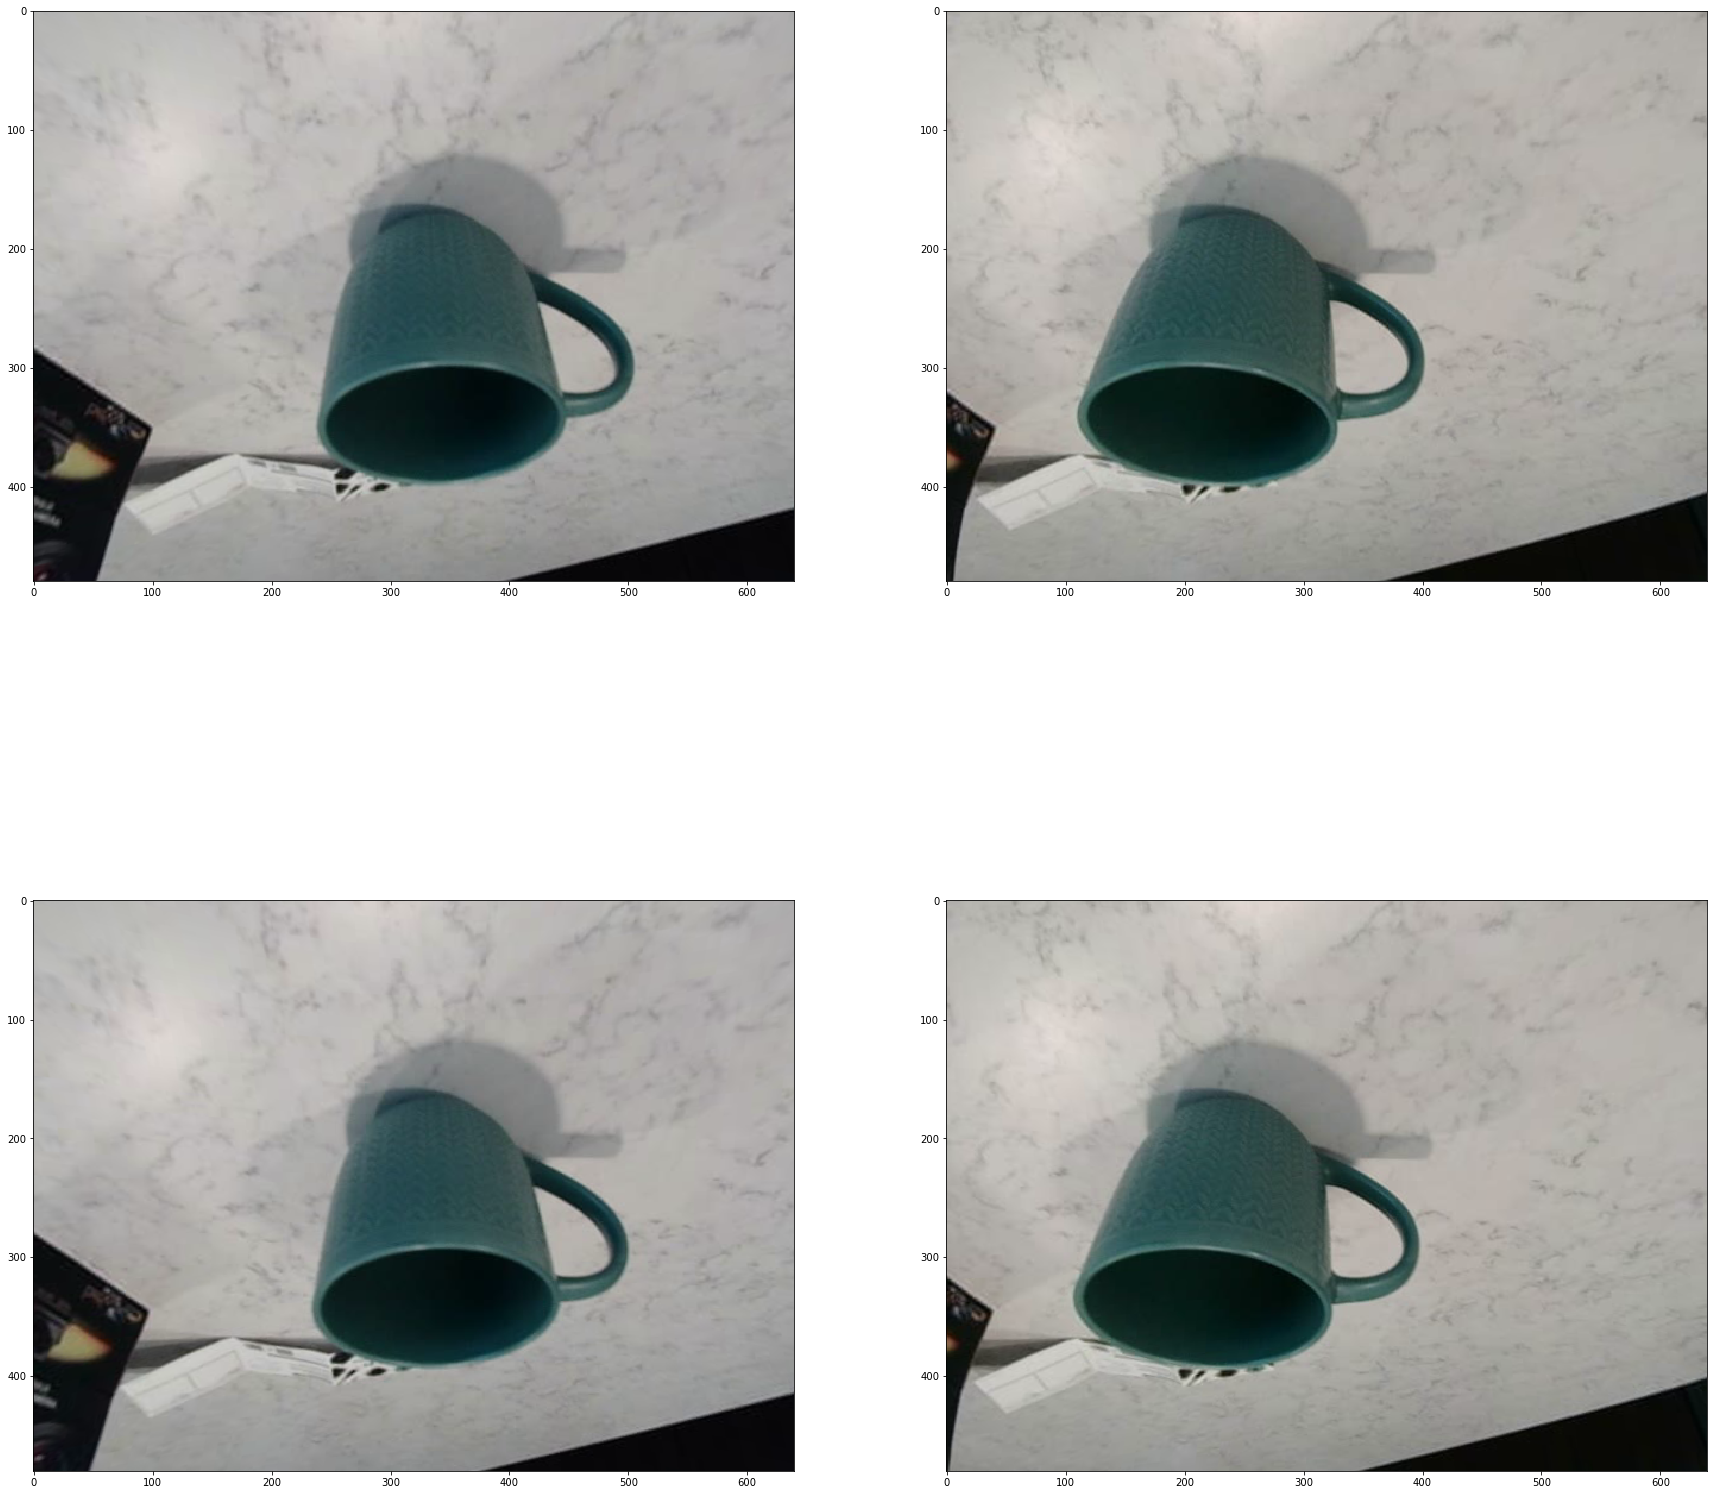

In [1252]:
plt.figure(figsize=(30,30))
plt.subplot(2,2,1)
plt.imshow(im1L[:,:,::-1])
plt.subplot(2,2,2)
plt.imshow(im1R[:,:,::-1])
plt.subplot(2,2,3)
plt.imshow(im2L[:,:,::-1])
plt.subplot(2,2,4)
plt.imshow(im2R[:,:,::-1])
plt.show()

## Create DepthMap from Stereo

In [1253]:
im1LG = cv2.cvtColor(im1L, cv2.COLOR_BGR2GRAY)
im1RG = cv2.cvtColor(im1R, cv2.COLOR_BGR2GRAY)

im2LG = cv2.cvtColor(im2L, cv2.COLOR_BGR2GRAY)
im2RG = cv2.cvtColor(im2R, cv2.COLOR_BGR2GRAY)

In [1300]:
numDisp = 64
minDisp = 8
stereoL = cv2.StereoSGBM_create(minDisp, numDisp,blockSize=30,speckleRange=5,mode=1);
stereoR = cv2.ximgproc.createRightMatcher(stereoL);
wlsFilter = cv2.ximgproc.createDisparityWLSFilter(stereoL);
wlsFilter.setLambda(8000)
wlsFilter.setSigmaColor(2.0)

In [1301]:
dispL = stereoL.compute(im1LG, im1RG)
dispR = stereoR.compute(im1RG, im1LG)
disp = wlsFilter.filter(dispL,im1LG,im1RG,dispR)
disp = disp / 16.0

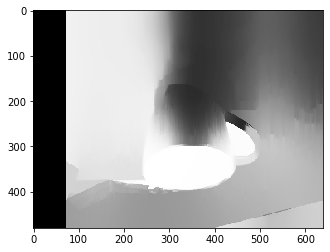

In [1302]:
normDisp = ((disp) - minDisp) / numDisp
plt.imshow(normDisp, cmap='gray')
plt.show()

In [1270]:
#intrinsics

fx = K1[0,0]
fy = K1[1,1]
favg = (fx+fy)/2

cx = K1[0,2]
cy = K1[1,2]
c = np.array([[cx,cy]]).T

In [1271]:
xx,yy = np.meshgrid(np.arange(im1LG.shape[1]), np.arange(im1LG.shape[0]))
dp_flatten = disp.flatten()
xx = xx.flatten()
yy = yy.flatten()
mask = (dp_flatten > 0)

pix_coords = np.vstack((xx,yy))
pix_valid = pix_coords[:,mask]

baseline = 60

pix_transform = (pix_coords[:,mask] - c) * (baseline / (dp_flatten[mask]))
z = (baseline * favg) / dp_flatten[mask]

x = pix_transform[0,:]
y = pix_transform[1,:]

baseline = 60 <br>
pix/mm = 0.5(640pix/4.8mm) + 0.5(480pix/3.6mm) <br>
pix/mm = 133.333333 <br>

In [1161]:
from skimage.measure import ransac
from skimage.transform import AffineTransform

In [1162]:
def featureMatching1(im1,im2):
    orb = cv2.ORB_create()
    
    kp1, des1 = orb.detectAndCompute(im1, None)
    kp2, des2 = orb.detectAndCompute(im2, None)
    
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.4*n.distance:
            good.append(m)
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)
    
    #ransac
    model, inliers = ransac( (src_pts, dst_pts), 
                            AffineTransform, min_samples=4, residual_threshold=4, max_trials=40)
    
    
    
    ## beginning of unnecessary
    n_inliers = np.sum(inliers)
    inlier_kp_left = [ cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers] ]
    inlier_kp_right = [ cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers] ]
    placehold_matches = [cv2.DMatch(idx,idx,1) for idx in range(n_inliers)]
    
    plt.figure(figsize=(15,15))
    final_img = cv2.drawMatches( im1, inlier_kp_left, im2, inlier_kp_right, placehold_matches, None )
    plt.imshow(final_img)
    plt.show()
    ## end of unnecessary
    
    
    return src_pts[inliers], dst_pts[inliers]
def featureMatching(im1,im2):
    orb = cv2.ORB_create()
    
    kp1, des1 = orb.detectAndCompute(im1, None)
    kp2, des2 = orb.detectAndCompute(im2, None)
    
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)
    
    #ransac
    model, inliers = ransac( (src_pts, dst_pts), 
                            AffineTransform, min_samples=4, residual_threshold=8, max_trials=40)
    
    
    return src_pts[inliers], dst_pts[inliers]

In [1163]:
disp = stereoDisparity(im1L, im1R)
pts3D = stereoTriangulate(disp,K1, baseline=133.333333*60)

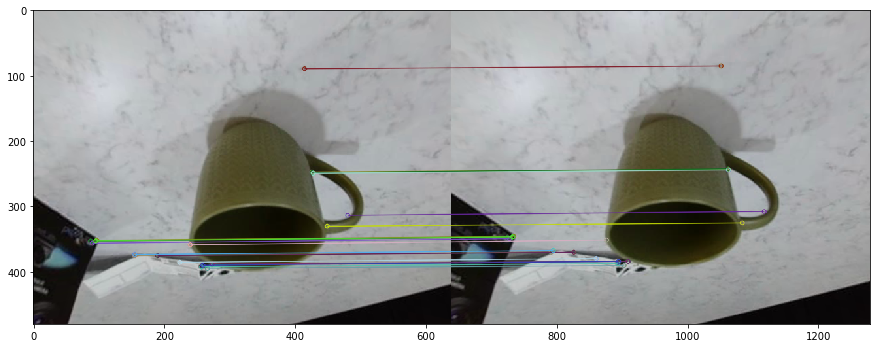

In [1164]:
src_ptsfl, dst_ptsfl = featureMatching1(im1L, im2L)

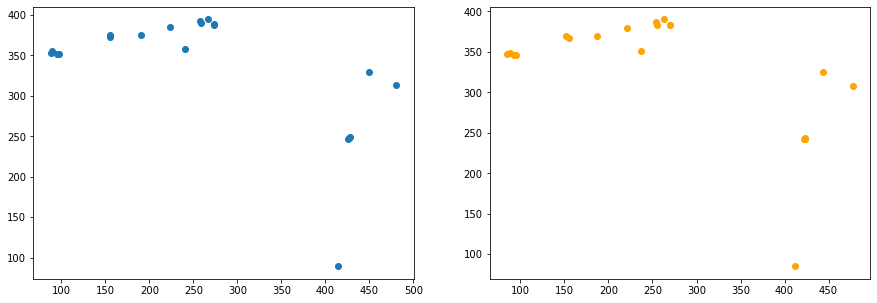

In [1165]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.scatter(src_ptsfl[:,0], src_ptsfl[:,1])
ax = fig.add_subplot(1,2,2)
ax.scatter(dst_ptsfl[:,0], dst_ptsfl[:,1],color='orange')
plt.show()

In [1166]:
print(src_ptsfl.max(axis=0))
print(dst_ptsfl.max(axis=0))

[480.74356 394.56003]
[477.75757 390.24002]


## Get 3d-points from Feature-Matching

In [1209]:
src_pts = src_ptsfl.astype(np.uint8)
dst_pts = dst_ptsfl.astype(np.uint8)

mask = (disp > 0)
pt_mask = np.zeros(disp.shape,dtype=bool)
pt_mask[ src_pts[:,1], src_pts[:,0] ] = True # mark all src coords at True
pt_mask = pt_mask & mask

src_mask = pt_mask[ src_pts[:,1], src_pts[:,0] ]

src_ft = src_pts[src_mask,:]

dst_ft = dst_pts[src_mask,:]
dst_ft = dst_ft.astype(np.float32)

disp_ft = disp[ src_pts[:,1], src_pts[:,0] ]
disp_ft = disp_ft[src_mask]


In [1210]:
def featureTriangulate(pts, disp_pts, K, baseline=60):
    fx = K[0,0]
    fy = K[1,1]
    favg = (fx+fy)/2

    cx = K[0,2]
    cy = K[1,2]
    c = np.array([[cx,cy]]).T
    
    z = (baseline*favg) / disp_pts;
    pts_t = (pts.T-c)*(baseline/disp_pts)
    pts3 = np.vstack((pts_t,z))
    return pts3

In [1211]:
pts3D_feature = featureTriangulate(src_ft,disp_ft,K1, baseline=60)

In [1212]:
print(pts3D_feature.shape, dst_ft.shape)

(3, 4) (4, 2)


## Setup PnP problem

In [1226]:
extr_R,_ = cv2.Rodrigues(initR.T)
extr_T = -initR.T@initT
#ret,rvec,tvec,_ = cv2.solvePnPRansac(pts3D_feature.T, dst_ft, K1, D1, useExtrinsicGuess=True, rvec=extr_R,flags=cv2.SOLVEPNP_SQPNP) # cv2.SOLVEPNP_SQPNP

In [1239]:
ret,rvec,tvec = cv2.solvePnP(pts3D_feature.T, dst_ft, K1, D1, useExtrinsicGuess=True, rvec=extr_R,flags=cv2.SOLVEPNP_SQPNP) # cv2.SOLVEPNP_SQPNP

In [1240]:
#rvec,tvec = cv2.solvePnPRefineLM(pts3D_feature.T, dst_ft, K1,D1, extr_R,extr_T)

In [1241]:
rot,_ = cv2.Rodrigues(rvec)

In [1242]:
print(rvec,'\n\n',tvec)

[[-0.02550833]
 [-0.62625589]
 [-0.20880868]] 

 [[165.43177091]
 [-24.53371484]
 [ 28.23811474]]


## Visualize

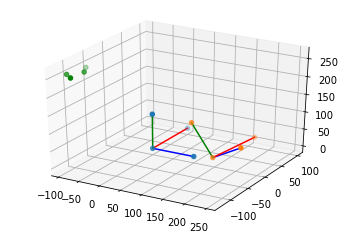

In [1243]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

visual(np.eye(3), np.array([[0,0,0]]).T, ax,size=100)
visual(rot,tvec,ax,size=100)
ax.scatter(pts3D_feature[0,:], pts3D_feature[1,:], pts3D_feature[2,:],c='green')
plt.show()